test_images/test6.jpg
test_images/test5.jpg
test_images/test4.jpg
test_images/test1.jpg
test_images/test3.jpg
test_images/test2.jpg


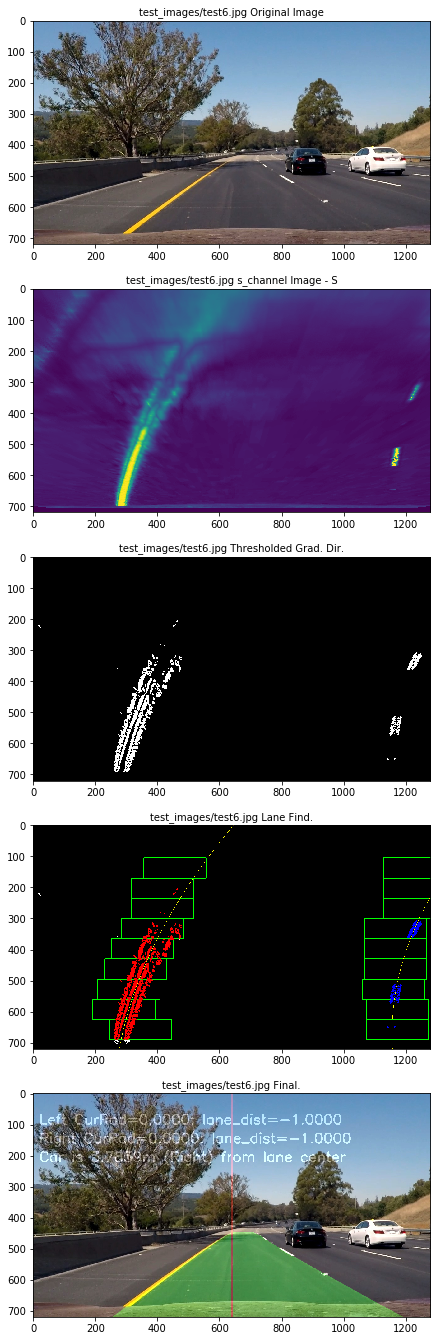

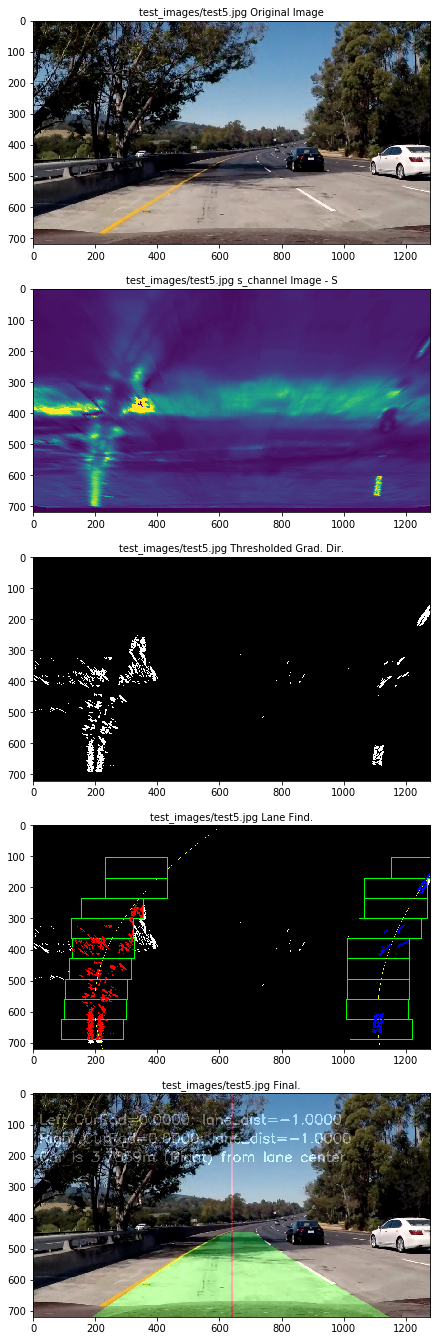

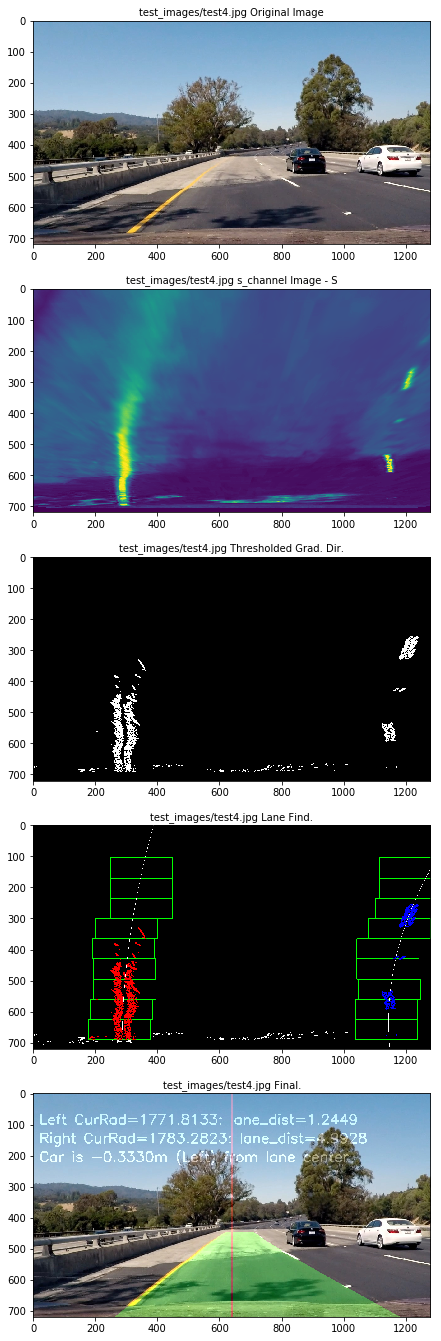

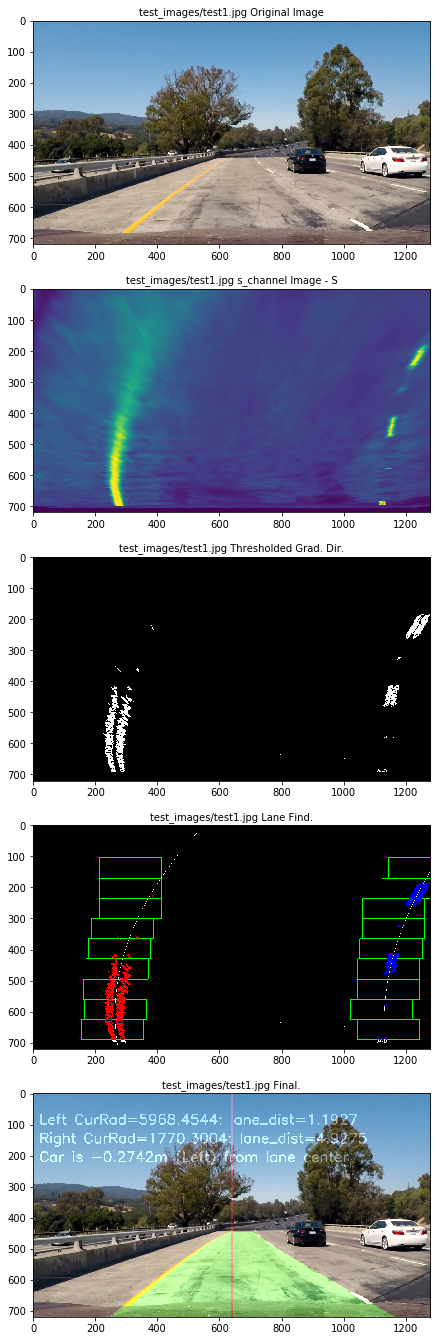

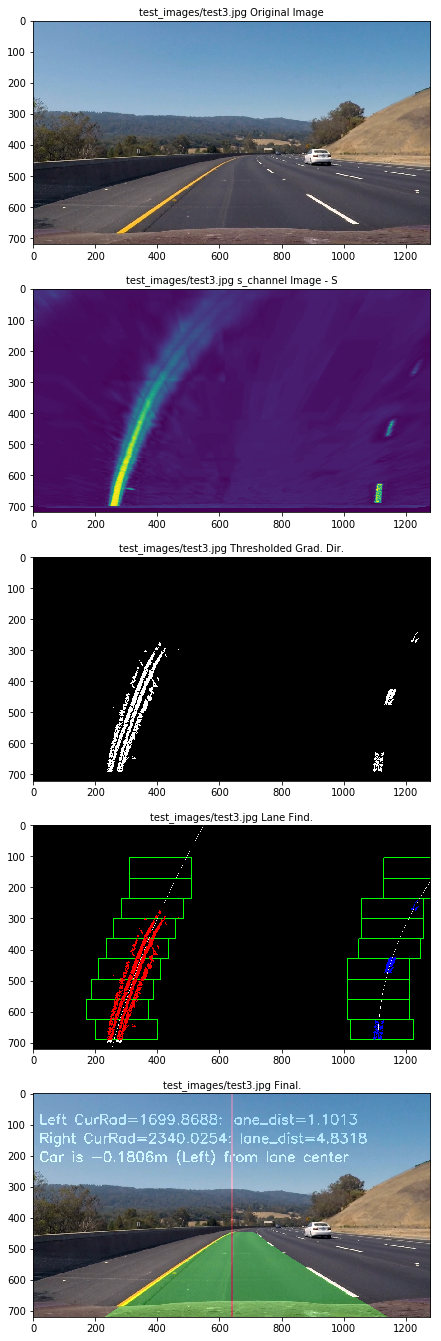

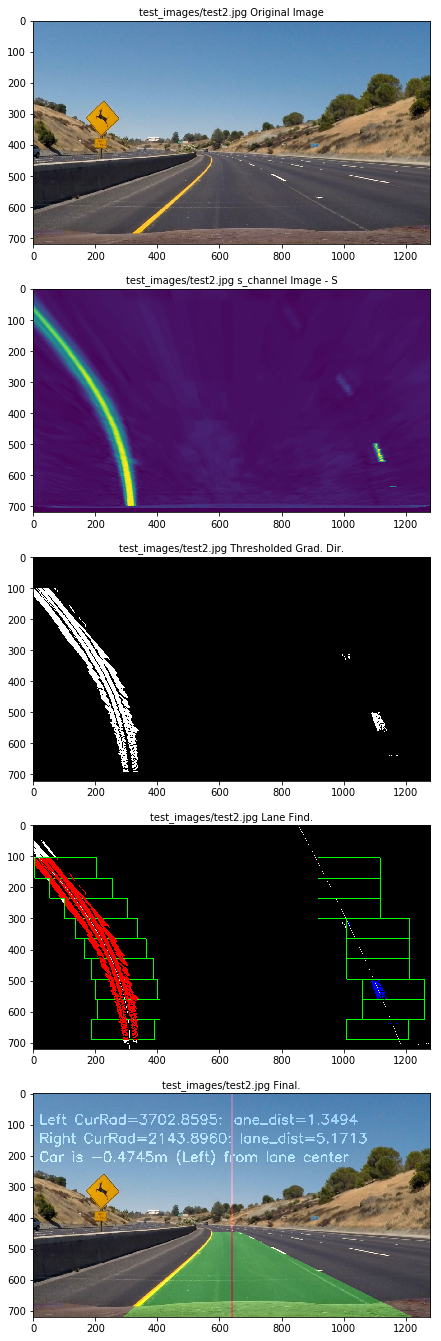

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from lane_lines import LaneLines

for file in glob.glob('test_images/*test*.jpg'):
    # Use a new object for each image as they are from different scenes.
    lanes = LaneLines('camera_cal')
    print (file)
    img = mpimg.imread(file)
    final = lanes.process_image(img)
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(20, 20))

    ax1.imshow(img)
    ax1.set_title(file + ' Original Image', fontsize=10)

    ax2.imshow(lanes.source_channel)
    ax2.set_title(file + ' s_channel Image - S', fontsize=10)

    ax3.imshow(lanes.binary_warped, cmap='gray')
    ax3.set_title(file + ' Thresholded Grad. Dir.', fontsize=10)

    ax4.imshow(lanes.lane_find_visualization)
    ax4.set_title(file + ' Lane Find.', fontsize=10)

    ax5.imshow(final)
    ax5.set_title(file + ' Final.', fontsize=10)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from lane_lines import LaneLines

for file in glob.glob('test_images/*test*.jpg'):
    # Use a new object for each image as they are from different scenes.
    lanes = LaneLines('camera_cal')
    print (file)
    img = mpimg.imread(file)
    final = lanes.process_image(img)
    f, (ax1) = plt.subplots(1, 1, figsize=(20, 20))

    ax1.imshow(final)



In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from lane_lines import LaneLines

for file in glob.glob('test_images/*test*.jpg'):
    # Use a new object for each image as they are from different scenes.
    lanes = LaneLines('camera_cal')
    print (file)
    img = mpimg.imread(file)
    final = lanes.process_image(img)
    binary = lanes.binary_warped
    binary = 
    final = np.hstack((final, lanes.lane_find_visualization))

        
    f, (ax1) = plt.subplots(1, 1, figsize=(20, 20))

    ax1.imshow(final)
    



In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from lane_lines import LaneLines

for file in glob.glob('test_images/*test*.jpg'):
    # Use a new object for each image as they are from different scenes.
    lanes = LaneLines('camera_cal')
    print (file)
    img = mpimg.imread(file)
    final = lanes.process_image(img)
    f, (ax1) = plt.subplots(1, 1, figsize=(20, 20))
    ax1.imshow(lanes.binary_warped)
    ax1.set_title(file + ' Lane Find.', fontsize=10)



In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from lane_lines import LaneLines

lanes = LaneLines('camera_cal')

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lanes.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
# debug version
-


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from lane_lines import LaneLines

lanes = LaneLines('camera_cal')

white_output = 'test_videos_output/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(lanes.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from lane_lines import LaneLines

lanes = LaneLines('camera_cal')

white_output = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(lanes.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)